# Run our regressions over a 5yr period for resampled fixed income volume data, MOVE Index, and the weekly Primary Dealer Data

In [1]:
!pip install yellowbrick
!pip install -U seaborn
!pip install statsmodels
!pip install XlsxWriter
!pip install openpyxl

     |████████████████████████████████| 276kB 18.1MB/s eta 0:00:01
     |████████████████████████████████| 286kB 11.3MB/s eta 0:00:01
  Found existing installation: seaborn 0.9.0
    Uninstalling seaborn-0.9.0:
      Successfully uninstalled seaborn-0.9.0
     |████████████████████████████████| 153kB 4.7MB/s eta 0:00:01
     |████████████████████████████████| 245kB 7.7MB/s eta 0:00:01
  Stored in directory: /home/jupyterlab/.cache/pip/wheels/2a/77/35/0da0965a057698121fc7d8c5a7a9955cdbfb3cc4e2423cad39
Successfully built et-xmlfile


In [16]:
import pandas as pd
import numpy as np

import datetime as dt 
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.mode.chained_assignment = None
pd.set_option('display.max_rows', None)
import warnings
warnings.filterwarnings('ignore')

import statsmodels.api as sm

# for the Q-Q plots
import scipy.stats as stats

# for linear regression
from sklearn.linear_model import LinearRegression

# to split and standarize the dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# to evaluate the regression model
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

import openpyxl
from openpyxl import Workbook

# a library for visualisation of machine learning model performance
from yellowbrick.regressor import ResidualsPlot

import pickle

### Load our datasets

In [3]:
fi_daily_trades = "DailyTradeCounts_2016_2020.xlsx"
FT_pg1 = pd.read_excel(fi_daily_trades, sheet_name="20160101_20181130")
FT_pg2 = pd.read_excel(fi_daily_trades, sheet_name="20181201_20200730")
FT_volumes = pd.concat([FT_pg1,FT_pg2])

move_all = "MOVE Index 16 18.xlsx"
move_daily1 = pd.read_excel(move_all, sheet_name="Sheet1", 
                           header=1,skiprows=5)
move_index = "MOVE Index Data.xlsx"
move_daily2 = pd.read_excel(move_index, sheet_name="2yr Daily", 
                           header=1,skiprows=4)

In [18]:
primary_dealers = "NY Fed Primary Dealer Trade Volumes.xlsx"
dealer_volumes_df = pd.read_excel(primary_dealers, sheet_name="Sheet1")

### We'll take each dataset and clean them up before merging into a single dataframe.

### Let's first review the MOVE Index

In [5]:
move_daily1.rename(columns={'Date':'Day','Last Px': 'Date', 'Unnamed: 2':'Last Px'}, inplace=True)
move_daily1.head()

,Day,Date,Last Px,Unnamed: 3
0,Tu,2018-07-31 00:00:00,46.5038,
1,Mo,2018-07-30 00:00:00,49.4151,
2,,,,
3,Fr,2018-07-27 00:00:00,48.8313,
4,Th,2018-07-26 00:00:00,49.2705,


In [6]:
#stitch the files together
move_daily = pd.concat([move_daily2,move_daily1],ignore_index=True)

In [7]:
#Clean up the data

move_daily.drop(['Day','Unnamed: 3'], axis=1, inplace=True)
move_daily.dropna(inplace=True)
move_daily.reset_index(drop=True, inplace=True)

move_index= move_daily[['Date','Last Px']]
move_index.rename(columns={'Last Px': 'MOVE Index'}, inplace=True)
move_index['MOVE Index'] = pd.to_numeric(move_index['MOVE Index'], errors='coerce')
move_index['Date'] = pd.to_datetime(move_index['Date'], errors='coerce')
move_index["Date"] = pd.to_datetime(move_index["Date"], format = '%Y%m').dt.to_period('d')
move_index = move_index.dropna()
move_index = move_index.reset_index(drop=True)
move_index.tail()


,Date,MOVE Index
1154,2015-12-25,65.4655
1155,2015-12-24,65.4655
1156,2015-12-23,66.0201
1157,2015-12-22,66.8957
1158,2015-12-21,66.3699


### Now we can resample the data

**Resample the daily data into weekly to compare with the weekly dealer volumes**

In [8]:
#fix the starting point of the move index to align weekly time series
date = '2016-01-04'
move_index = move_index[move_index['Date']>(date)]

from datetime import datetime
move_index['Date'] = pd.to_datetime(move_index['Date'].astype(str), format='%Y-%m-%d')

move_index.set_index('Date', inplace=True)

#align our dates to fall on same day as others 
move_weekly = move_index['MOVE Index'].resample('W-WED', origin='start').mean()

move_weekly = move_weekly.reset_index()
move_weekly.head()

,Date,MOVE Index
0,2016-01-06,71.55325
1,2016-01-13,72.53234
2,2016-01-20,77.77548
3,2016-01-27,76.11602
4,2016-02-03,75.11190


### Clean up the trade volume dataset

In [9]:
#Clean up the date format first
from datetime import datetime
FT_volumes['Date'] = pd.to_datetime(FT_volumes['Date'].astype(str), format='%Y-%m-%d')

FT_volumes.rename(columns={'Non Premium': 'FI Trades'}, inplace=True)

#convert daily data to weekly for each client
weekly_trades = FT_volumes.groupby("Client").resample('W-Wed', 
                                                        label='right', closed = 'right', on='Date').sum().reset_index().sort_values(by='Date')

weekly_trades.head()

,Client,Date,Total Trades,FI Trades,MBS/TBA,MULTI CURRENCY TRADES,Repos,TRI-PARTY TRADES,IFT,MERGEDTRADES,OTHERTRADES,MAXENTITY,Others,TOTALDOWNLOADCOUNTS,Enity Count,TRIPARTYDEALS,MBS/TBA,OTHERS,ENTITY COUNT,MAXENTITYCOUNTMTD
0,ACC,2016-01-06,101,91,10.0,0,0,0,0,0.0,0.0,4.0,0.0,0,4.0,0,0.0,0.0,0.0,0.0
2379,CNA,2016-01-06,1202,964,0.0,7,0,231,0,0.0,0.0,20.0,0.0,14799,20.0,8,0.0,0.0,0.0,0.0
245,BMO,2016-01-06,25214,18529,305.0,17,0,6363,0,0.0,0.0,52.0,0.0,1918523,52.0,184,0.0,0.0,0.0,0.0
240,AMH,2016-01-06,0,0,0.0,0,0,0,0,0.0,0.0,3.0,0.0,0,3.0,0,0.0,0.0,0.0,0.0
2139,CIT,2016-01-06,23667,2572,867.0,49,0,20104,75,0.0,0.0,8.0,0.0,2915808,8.0,143,0.0,0.0,0.0,0.0


In [10]:
#aggregate down the dataframe to just the date and activity
fiweekly_trades = weekly_trades.groupby(['Date'])['FI Trades'].agg('sum')

fiweekly_trades.head()

Date
2016-01-06     583640
2016-01-13    1018882
2016-01-20     868001
2016-01-27    1006613
2016-02-03    1080292
Name: FI Trades, dtype: int64

### Finally, we'll clean up the primary dealer dataset


In [19]:
#now we standarize and clean up the NY Fed data

dealer_volumes_df = dealer_volumes_df.pivot(index="As Of Date",
                                            columns="Timeseries", 
                                            values='Value (millions)') \
       .reset_index().rename_axis(None, axis=1)
dealer_volumes_df.rename(columns={'As Of Date': 'Date',
                                  'PDTRGSC-L2':'< 2yr duration',
                                  'PDTRGSC-G2L3':'2-3yr duration',
                                  'PDTRGSC-G3L6':'3-6yr duration',
                                  'PDTRGSC-G6L7':'6-7yr duration',
                                  'PDTRGSC-G7L11':'7-11yr duration',
                                  'PDTRGSC-G11':'> 11yr duration',
                                  }, 
                         inplace=True)

print(dealer_volumes_df.head())

         Date  > 11yr duration  2-3yr duration  3-6yr duration  \
0  2015-01-07            44433           51914          126481   
1  2015-01-14            53779           68112          131245   
2  2015-01-21            48109           60206          137981   
3  2015-01-28            41320           44604          106120   
4  2015-02-04            54670           61332          166651   

   6-7yr duration  7-11yr duration  < 2yr duration  
0           42401            88188           70987  
1           32660           105209           75816  
2           27971           109938           83965  
3           26450            79307           73456  
4           60947           103601          105996  


In [20]:
dealer_volumes_df.columns

Index(['Date', '> 11yr duration', '2-3yr duration', '3-6yr duration',
       '6-7yr duration', '7-11yr duration', '< 2yr duration'],
      dtype='object')

In [21]:

columnTitles = dealer_volumes_df.columns

dealer_volumes_df = dealer_volumes_df.reindex(columns=columnTitles)
# dealer_volumes_df = dealer_volumes_df[columnsTitles[1:]].apply(pd.to_numeric, errors='coerce')

dealer_volumes_df['Date']= pd.to_datetime(dealer_volumes_df['Date'])
dealer_volumes_df[['< 2yr duration','2-3yr duration',
                 '3-6yr duration','6-7yr duration',
                 '7-11yr duration','> 11yr duration']].astype(np.float64)

dealer_volumes_df["All Treasury Volume"] = dealer_volumes_df[columnTitles[1:]].sum(axis=1) 
# dealer_volumes_df['> 11yr series'] = pd.to_numeric(dealer_volumes_df['> 11yr series'])
print(dealer_volumes_df.dtypes)
print(dealer_volumes_df[dealer_volumes_df['All Treasury Volume'].isnull()].shape)
dealer_volumes_df.head(5)

Date                   datetime64[ns]
> 11yr duration                 int64
2-3yr duration                  int64
3-6yr duration                  int64
6-7yr duration                  int64
7-11yr duration                 int64
< 2yr duration                  int64
All Treasury Volume             int64
dtype: object
(0, 8)


,Date,> 11yr duration,2-3yr duration,3-6yr duration,6-7yr duration,7-11yr duration,< 2yr duration,All Treasury Volume
0,2015-01-07,44433,51914,126481,42401,88188,70987,424404
1,2015-01-14,53779,68112,131245,32660,105209,75816,466821
2,2015-01-21,48109,60206,137981,27971,109938,83965,468170
3,2015-01-28,41320,44604,106120,26450,79307,73456,371257
4,2015-02-04,54670,61332,166651,60947,103601,105996,553197


In [23]:
#Let's combine our cleaned-up dataframes
df_wkly = pd.merge_asof(fiweekly_trades,dealer_volumes_df[['Date','< 2yr duration','2-3yr duration',
                 '3-6yr duration','6-7yr duration',
                 '7-11yr duration','> 11yr duration','All Treasury Volume']].sort_values('Date'),on='Date')
# #the move index has only 2yrs worth of data, keeping a separate dataset in df_moves
df_all = pd.merge_asof(df_wkly, move_weekly[['Date','MOVE Index']].sort_values('Date'), on= 'Date')

In [6]:
# df_all.tail()

In [26]:
#save our dataset
pickle.dump(df_all, open( "df_datasets.p", "wb" ) )

In [3]:
#reload the dataframe

data = pickle.load( open( "df_datasets.p", "rb" ) )
data.head()

,Date,FI Trades,< 2yr duration,2-3yr duration,3-6yr duration,6-7yr duration,7-11yr duration,> 11yr duration,All Treasury Volume,MOVE Index
0,2016-01-06,583640,111380,50098,118190,35862,66566,28720,410816,71.55325
1,2016-01-13,1018882,102177,66881,125401,33314,110069,44324,482166,72.53234
2,2016-01-20,868001,84879,58885,132007,30365,99224,45083,450443,77.77548
3,2016-01-27,1006613,94864,52351,123178,28893,82431,32130,413847,76.11602
4,2016-02-03,1080292,102335,50371,155290,50161,94520,38999,491676,75.11190


In [4]:
data = data.set_index('Date')
data = data.astype(np.float64)
data.head()

,FI Trades,< 2yr duration,2-3yr duration,3-6yr duration,6-7yr duration,7-11yr duration,> 11yr duration,All Treasury Volume,MOVE Index
Date,,,,,,,,,
2016-01-06,583640.0,111380.0,50098.0,118190.0,35862.0,66566.0,28720.0,410816.0,71.55325
2016-01-13,1018882.0,102177.0,66881.0,125401.0,33314.0,110069.0,44324.0,482166.0,72.53234
2016-01-20,868001.0,84879.0,58885.0,132007.0,30365.0,99224.0,45083.0,450443.0,77.77548
2016-01-27,1006613.0,94864.0,52351.0,123178.0,28893.0,82431.0,32130.0,413847.0,76.11602
2016-02-03,1080292.0,102335.0,50371.0,155290.0,50161.0,94520.0,38999.0,491676.0,75.11190


In [5]:
# to interpolate the missing values, we'll take the average between nearest values of the NaN
data = data.interpolate(method ='linear', limit_direction ='forward')

print(data.isnull().sum())
print(data.shape)


FI Trades              0
< 2yr duration         0
2-3yr duration         0
3-6yr duration         0
6-7yr duration         0
7-11yr duration        0
> 11yr duration        0
All Treasury Volume    0
MOVE Index             0
dtype: int64
(240, 9)


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 240 entries, 2016-01-06 to 2020-08-05
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   FI Trades            240 non-null    float64
 1   < 2yr duration       240 non-null    float64
 2   2-3yr duration       240 non-null    float64
 3   3-6yr duration       240 non-null    float64
 4   6-7yr duration       240 non-null    float64
 5   7-11yr duration      240 non-null    float64
 6   > 11yr duration      240 non-null    float64
 7   All Treasury Volume  240 non-null    float64
 8   MOVE Index           240 non-null    float64
dtypes: float64(9)
memory usage: 18.8 KB


In [7]:
data.describe()

,FI Trades,< 2yr duration,2-3yr duration,3-6yr duration,6-7yr duration,7-11yr duration,> 11yr duration,All Treasury Volume,MOVE Index
count,2.400000e+02,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000
mean,1.121874e+06,83967.533333,51867.058333,120591.308333,33608.275000,84969.766667,44534.275000,419538.216667,62.357185
std,2.511437e+05,21777.962180,15501.331099,25969.692440,12805.729371,21511.819334,14572.473425,84744.290981,13.430115
min,2.278700e+05,27905.000000,19154.000000,62883.000000,12883.000000,28913.000000,13697.000000,215319.000000,44.489960
25%,9.776462e+05,68442.750000,42204.500000,101031.000000,24052.250000,72257.500000,34625.000000,367106.750000,52.376685
50%,1.078632e+06,80999.500000,47659.500000,117926.000000,29260.000000,81765.500000,42250.500000,408403.000000,60.021010
75%,1.256252e+06,97347.750000,61508.000000,134917.250000,40808.750000,94995.500000,49534.000000,451619.250000,69.655465
max,2.141071e+06,171685.000000,110475.000000,249938.000000,90630.000000,178007.000000,111803.000000,875601.000000,129.908000


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


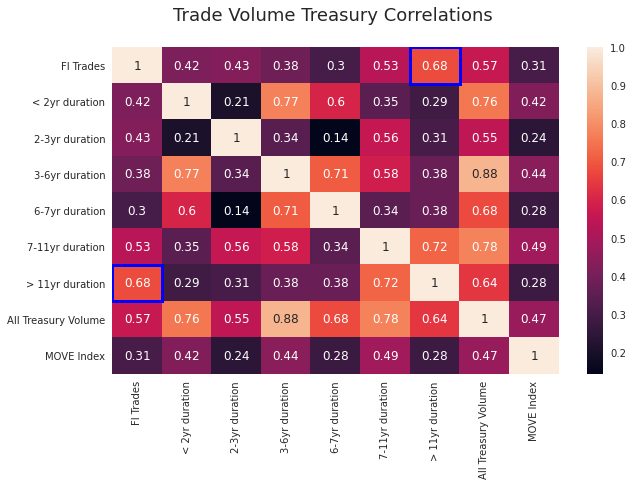

In [73]:
from matplotlib.patches import Rectangle

#Before beginning our analysis, let's first pick our the best predictors but mindful of multicollinearity
features = data[data.columns[1:]]

#calc correlation matrix
corr_mat = data.corr(method ='pearson')

#plot matrix
figure = plt.figure(figsize=(10,6))
ax = sns.heatmap(data=corr_mat, annot=True)
plt.title('Trade Volume Treasury Correlations \n', fontsize = 18)

#adding 2 heatmap cells accessed using their cell location (2,3) to change the cell color or add the border
ax.add_patch(Rectangle((6,0), 1, 1, edgecolor='blue', fill=False, lw=3))
ax.add_patch(Rectangle((0,6), 1, 1, edgecolor='blue', fill=False, lw=3))

plt.savefig("corr_matrix.png", dpi = 65);

In [62]:
#let's just view longest duration, and total volume which incorporates shorter-term maturities

features = data[['> 11yr duration','All Treasury Volume']]
features.head()

,> 11yr duration,All Treasury Volume
Date,,
2016-01-06,3.285501,3.084304
2016-01-13,3.306572,3.086832
2016-01-20,3.307344,3.085774
2016-01-27,3.291205,3.084423
2016-02-03,3.300629,3.087132


In [63]:
# let's separate into training and testing set
# using the sklearn function below
# features = data[data.columns[1:]]
X_train, X_test, y_train, y_test = train_test_split(
    features,
    data['FI Trades'],
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((168, 2), (72, 2), (168,), (72,))

In [64]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [65]:
# instantiate a lineear model
linreg = LinearRegression()

# train the model
linreg.fit(scaler.transform(X_train), y_train)

# make predictions on the train set and calculate
# the mean squared error
print('Train set')
pred = linreg.predict(scaler.transform(X_train))
print('Linear Regression mse: {}'.format(mean_squared_error(y_train, pred)))

# make predictions on the test set and calculate
# the mean squared error
print('Test set')
pred = linreg.predict(scaler.transform(X_test))
print('Linear Regression mse: {}'.format(mean_squared_error(y_test, pred)))
print()

Train set
Linear Regression mse: 143734.0765905837
Test set
Linear Regression mse: 243708.65515224662



In [43]:
# calculate the residuals

error = y_test - pred

In [1]:
import seaborn as sns
print (sns.__version__)

0.11.1


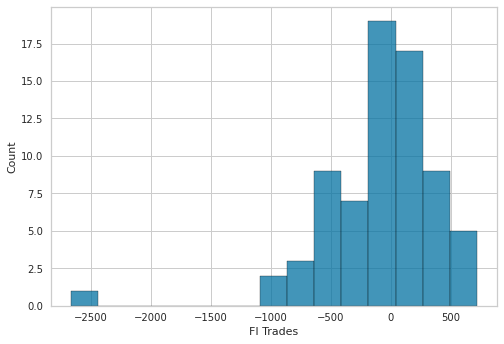

In [75]:
# we will make a histogram to determine if the residuals
# are normally distributed with mean value at 0

sns.histplot(error, bins=15)

plt.savefig("fi_histplot.png", dpi = 65);

We see that the residuals show a fairly normal distribution centered at 0. Not perfect, by visual inspection there is some skew towards the right, with a few higher unusual values towards the left of the distribution.

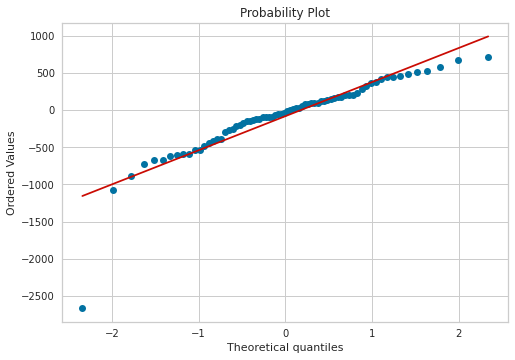

In [76]:
# we can better visualize residuals distribution with 
# a Q-Q plot. If the residuals are normally distributed
# the dots should adjust to the 45 degree line

stats.probplot(error, dist="norm", plot=plt)
plt.savefig("prob_plot.png", dpi = 65);
plt.show();

From the Q-Q plot we see more easily how the residuals deviate from the tails of the distribution, thus, they are not normally distributed.

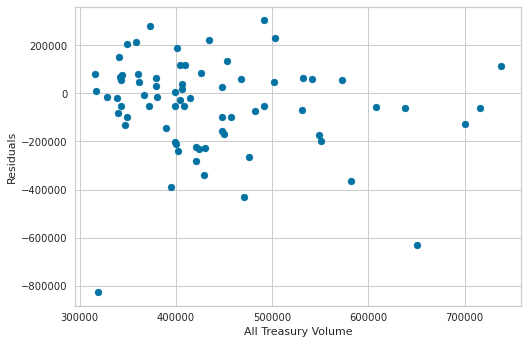

In [46]:
# plot the residuals vs one of the independent variables

plt.scatter(x=X_test['All Treasury Volume'], y=error)
plt.xlabel('All Treasury Volume')
plt.ylabel('Residuals');

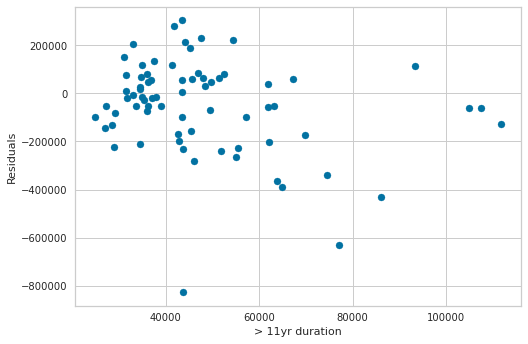

In [48]:
# plot the residuals vs one of the independent variables

plt.scatter(x=X_test['> 11yr duration'], y=error)
plt.xlabel('> 11yr duration')
plt.ylabel('Residuals');

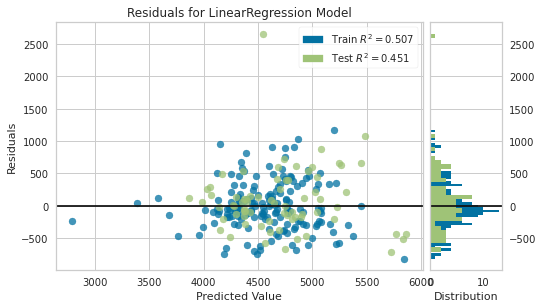

In [83]:
# yellowbricks allows you to visualise the residuals of the
# models after fitting a linear regression

from yellowbrick.regressor import ResidualsPlot

linreg = LinearRegression()
linreg.fit(scaler.transform(X_train), y_train)
visualizer = ResidualsPlot(linreg)

visualizer.fit(scaler.transform(X_train), y_train)  # Fit the training data to the model
visualizer.score(scaler.transform(X_test), y_test)  # Evaluate the model on the test data

ax.figure.tight_layout()
#this fixes the labels from getting cut off
plt.subplots_adjust(top=0.75)
plt.savefig("residual_multiplot.png", dpi = 65);
visualizer.poof();

On the right, we have the distribution of the residuals in the train and test sets. We see that it is not perfectly centered at 0.

On the left, we have the residuals vs the predicted value, we also see that the variance is not constant. Towards the extremes of the predictions, the model is under-estimating the outcome (most residuals are negative). And towards the center of the predictions, the model is over-estimating the outcome. So the residuals variance is not constant for all values.

### Transform the data to improve model fit
 - We will use the Box-Cox transformation

In [50]:
import scipy.stats as stats


# apply the box-cox transformation to the variables
data['> 11yr duration'], _ = stats.boxcox(data['> 11yr duration'])
data['All Treasury Volume'], _ = stats.boxcox(data['All Treasury Volume'])
data['FI Trades'], _ = stats.boxcox(data['FI Trades'])

# let's separate into training and testing set
X_train, X_test, y_train, y_test = train_test_split(
    data[['> 11yr duration','All Treasury Volume']],
    data['FI Trades'],
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((168, 2), (72, 2), (168,), (72,))

In [51]:
# let's scale the features

scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [52]:
# model build a new model using the transformed variables

# specify the model
linreg = LinearRegression()

# fit the model
linreg.fit(scaler.transform(X_train), y_train)

# make predictions and calculate the mean squared
# error over the train set
print('Train set')
pred = linreg.predict(scaler.transform(X_train))
print('Linear Regression mse: {}'.format(mean_squared_error(y_train, pred)))

# make predictions and calculate the mean squared
# error over the test set
print('Test set')
pred = linreg.predict(scaler.transform(X_test))
print('Linear Regression mse: {}'.format(mean_squared_error(y_test, pred)))
print()

Train set
Linear Regression mse: 143734.0765905837
Test set
Linear Regression mse: 243708.65515224662



In [53]:
 # calculate the residuals

error = y_test - pred

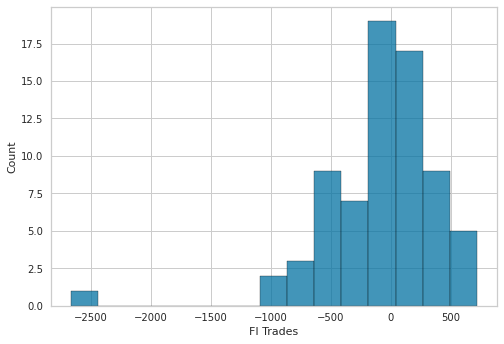

In [54]:
# we will make a histogram to determine if the residuals
# are normally distributed with mean value at 0

sns.histplot(error, bins=15);

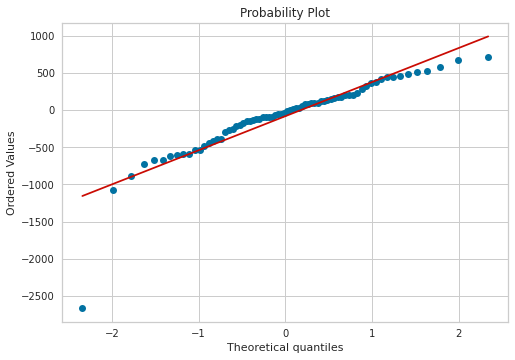

In [55]:
# we can better visualize residuasl distribution with 
# a Q-Q plot. If the residuals are normally distributed
# the dots should adjust to the 45 degree line

stats.probplot(error, dist="norm", plot=plt)
plt.show()

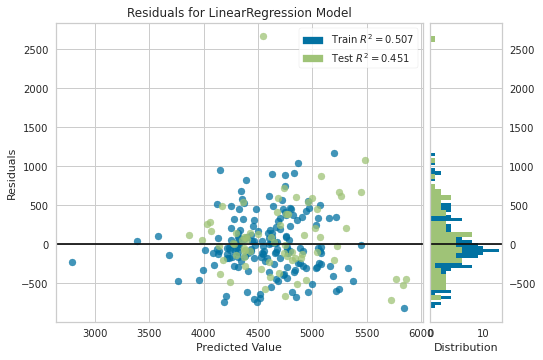

<AxesSubplot:title={'center':'Residuals for LinearRegression Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [56]:
# let's now do the analysis with yellowbrick

from yellowbrick.regressor import ResidualsPlot

linreg = LinearRegression()
linreg.fit(scaler.transform(X_train), y_train)
visualizer = ResidualsPlot(linreg)

visualizer.fit(scaler.transform(X_train), y_train)  # Fit the training data to the model
visualizer.score(scaler.transform(X_test), y_test)  # Evaluate the model on the test data
visualizer.poof()

In this case we didn't witness much of an improvement.  We need to keep digging for other
predicting variables to build a stronger model.